<a href="https://colab.research.google.com/github/GrzegorzMeller/AlgorithmsForMassiveData/blob/master/OCULAR_DISEASE_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip ocular-disease-recognition-odir5k.zip
!mkdir ODIR-5K/Validation_Images

In [21]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob

BATCH_SIZE = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

training_images_file = 'ODIR-5K/Training Images'
testing_images_file = 'ODIR-5K/Testing Images'
labels_file = 'ODIR-5K/data.xlsx'

diseases = {'abnormal pigment ': 'O', 'age-related macular degeneration': 'A', 'anterior segment image': 'DELETE', 'arteriosclerosis': 'NaN', 'asteroid hyalosis': 'O', 'atrophic change': 'O', 'atrophy': 'O', 'branch retinal artery occlusion': 'O', 'branch retinal vein occlusion': 'O', 'cataract': 'C', 'central retinal artery occlusion': 'O', 'central retinal vein occlusion': 'O', 'central serous chorioretinopathy': 'O', 'chorioretinal atrophy': 'O', 'chorioretinal atrophy with pigmentation proliferation': 'O', 'choroidal nevus': 'NaN', 'congenital choroidal coloboma': 'O', 'depigmentation of the retinal pigment epithelium': 'O', 'diabetic retinopathy': 'D', 'diffuse chorioretinal atrophy': 'O', 'diffuse retinal atrophy': 'O', 'drusen': 'O', 'dry age-related macular degeneration': 'A', 'epiretinal membrane': 'O', 'epiretinal membrane over the macula': 'O', 'fundus laser photocoagulation spots': 'O', 'glaucoma': 'G', 'glial remnants anterior to the optic disc': 'O', 'hypertensive retinopathy': 'H', 'hypertensive retinopathy,diabetic retinopathy': 'D', 'idiopathic choroidal neovascularization': 'O', 'image offset': 'DELETE', 'intraretinal hemorrhage': 'O', 'intraretinal microvascular abnormality': 'O', 'laser spot': 'O', 'lens dust': 'DELETE', 'low image quality': 'DELETE', 'low image quality,maculopathy': 'DELETE', 'macular coloboma': 'O', 'macular epiretinal membrane': 'O', 'macular hole': 'O', 'macular pigmentation disorder': 'NaN', 'maculopathy': 'O', 'mild nonproliferative retinopathy': 'D', 'moderate non proliferative retinopathy': 'D', 'morning glory syndrome': 'O', 'myelinated nerve fibers': 'O', 'myopia retinopathy': 'M', 'myopic maculopathy': 'M', 'myopic retinopathy': 'M', 'no fundus image': 'DELETE', 'normal fundus': 'N', 'old branch retinal vein occlusion': 'O', 'old central retinal vein occlusion': 'O', 'old chorioretinopathy': 'O', 'old choroiditis': 'NaN', 'optic disc edema': 'O', 'optic discitis': 'O', 'optic disk epiretinal membrane': 'O', 'optic disk photographically invisible': 'DELETE', 'optic nerve atrophy': 'O', 'oval yellow-white atrophy': 'O', 'pathological myopia': 'M', 'peripapillary atrophy': 'O', 'pigment epithelium proliferation': 'O', 'pigmentation disorder': 'O', 'post laser photocoagulation': 'O', 'post retinal laser surgery': 'O', 'proliferative diabetic retinopathy': 'D', 'punctate inner choroidopathy': 'O', 'refractive media opacity': 'O', 'retina fold': 'O', 'retinal artery macroaneurysm': 'O', 'retinal detachment': 'O', 'retinal pigment epithelial hypertrophy': 'O', 'retinal pigment epithelium atrophy': 'O', 'retinal pigmentation': 'O', 'retinal vascular sheathing': 'O', 'retinitis pigmentosa': 'O', 'retinochoroidal coloboma': 'O', 'rhegmatogenous retinal detachment': 'O', 'severe nonproliferative retinopathy': 'D', 'severe proliferative diabetic retinopathy': 'D', 'silicone oil eye': 'O', 'spotted membranous change': 'O', 'suspected abnormal color of  optic disc': 'O', 'suspected cataract': 'C', 'suspected diabetic retinopathy': 'D', 'suspected glaucoma': 'G', 'suspected macular epimacular membrane': 'O', 'suspected microvascular anomalies': 'O', 'suspected moderate non proliferative retinopathy': 'D', 'suspected retinal vascular sheathing': 'O', 'suspected retinitis pigmentosa': 'O', 'suspicious diabetic retinopathy': 'D', 'tessellated fundus': 'O', 'vascular loops': 'O', 'vessel tortuosity': 'O', 'vitreous degeneration': 'O', 'vitreous opacity': 'O', 'wedge white line change': 'O', 'wedge-shaped change': 'O', 'wet age-related macular degeneration': 'A', 'white vessel': 'O'}

#load labels to pandas
labels = pd.read_excel(labels_file, index_col=0) 
print(labels['Left-Diagnostic Keywords'][0])
print(diseases)

cataract
{'abnormal pigment ': 'O', 'age-related macular degeneration': 'A', 'anterior segment image': 'DELETE', 'arteriosclerosis': 'NaN', 'asteroid hyalosis': 'O', 'atrophic change': 'O', 'atrophy': 'O', 'branch retinal artery occlusion': 'O', 'branch retinal vein occlusion': 'O', 'cataract': 'C', 'central retinal artery occlusion': 'O', 'central retinal vein occlusion': 'O', 'central serous chorioretinopathy': 'O', 'chorioretinal atrophy': 'O', 'chorioretinal atrophy with pigmentation proliferation': 'O', 'choroidal nevus': 'NaN', 'congenital choroidal coloboma': 'O', 'depigmentation of the retinal pigment epithelium': 'O', 'diabetic retinopathy': 'D', 'diffuse chorioretinal atrophy': 'O', 'diffuse retinal atrophy': 'O', 'drusen': 'O', 'dry age-related macular degeneration': 'A', 'epiretinal membrane': 'O', 'epiretinal membrane over the macula': 'O', 'fundus laser photocoagulation spots': 'O', 'glaucoma': 'G', 'glial remnants anterior to the optic disc': 'O', 'hypertensive retinopat

In [0]:
def update_filenames(file_path):
  all_paths = []
  for element in glob.glob(file_path+"/*.jpg"):
    all_paths.append(element)
  paths = []

  for u_id in labels.index:
    labelL = ""
    labelR = ""
    diagnosticL = labels['Left-Diagnostic Keywords'][u_id]
    diagnosticR = labels['Right-Diagnostic Keywords'][u_id]
    diagnosticL = diagnosticL.split("，") 
    diagnosticR = diagnosticR.split("，") 
    #print(diagnosticL)
    for d in diagnosticL:
      if d in diseases:
          if labelL != "":
            labelL+="&"+diseases[d]
          else:
            labelL+=diseases[d]
      else:
          labelL+="DELETE"
    for d in diagnosticR:
      if d in diseases:
        if labelR != "":
          labelR+="&"+diseases[d]
        else:
          labelR+=diseases[d]
      else:
        labelR+="DELETE"

    if file_path+"/"+str(labels['Left-Fundus'][u_id]) in all_paths:
      filename = str(labels['Left-Fundus'][u_id]).split(".")
      os.rename(file_path+"/"+str(labels['Left-Fundus'][u_id]), file_path+"/"+filename[0]+"-"+labelL+".jpg")
      paths.append(file_path+"/"+str(labels['Left-Fundus'][u_id])+"/"+labelL)
  
    if file_path+"/"+str(labels['Right-Fundus'][u_id]) in all_paths:
      filename = str(labels['Right-Fundus'][u_id]).split(".")
      os.rename(file_path+"/"+str(labels['Right-Fundus'][u_id]), file_path+"/"+filename[0]+"-"+labelR+".jpg")
      paths.append(file_path+"/"+str(labels['Right-Fundus'][u_id])+"/"+labelR)
      
update_filenames(training_images_file)

In [26]:
N = 0
D=0
G=0
C=0
A=0
H=0
M=0
O = 0
MIX = 0
DELETE = 0
items_to_remove = []
for element in glob.glob("ODIR-5K/Training Images/*.jpg"):
  img_name = element.split("/")[-1]
  img_label = img_name.split("-")
  if img_label[-1] == "N.jpg":
    N += 1
  elif img_label[-1] == "D.jpg":
    D +=1
  elif img_label[-1] == "G.jpg":
    G +=1
  elif img_label[-1] == "C.jpg":
    C +=1
  elif img_label[-1] == "A.jpg":
    A +=1
  elif img_label[-1] == "H.jpg":
    H +=1
  elif img_label[-1] == "M.jpg":
    M +=1
  elif img_label[-1] == "O.jpg":
    O +=1
  elif "DELETE" in img_label[-1]:
    DELETE+=1
    items_to_remove.append(element)
  elif "&" in img_label[-1]:
    MIX +=1
    items_to_remove.append(element)

for e in items_to_remove:
  os.remove(e)
  
print(N, D, G, C, A, H, M, O, DELETE, MIX)
print(N+D+G+C+A+H+M+O)

2816 1386 218 262 237 104 237 756 0 0
6016


In [0]:
import random
#move randomly selected 1000 files to Validation Images directory
all_paths = []
for element in glob.glob("ODIR-5K/Training Images/*.jpg"):
  all_paths.append(element)
num_to_select = 800                          
list_of_random_items = random.sample(all_paths, num_to_select)
for element in list_of_random_items:
  p = element.split("/")
  os.replace(element, "ODIR-5K/Validation_Images/"+p[-1])

In [0]:
train_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*.jpg")
test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*.jpg")

In [30]:
for f in train_ds.take(5):
  print(f.numpy())

for f in test_ds.take(5):
  print(f.numpy())

b'ODIR-5K/Training Images/1130_right-N.jpg'
b'ODIR-5K/Training Images/1465_right-G.jpg'
b'ODIR-5K/Training Images/2754_right-N.jpg'
b'ODIR-5K/Training Images/101_right-O.jpg'
b'ODIR-5K/Training Images/3068_right-N.jpg'
b'ODIR-5K/Validation_Images/3263_left-N.jpg'
b'ODIR-5K/Validation_Images/668_right-D.jpg'
b'ODIR-5K/Validation_Images/2225_left-C.jpg'
b'ODIR-5K/Validation_Images/2748_left-N.jpg'
b'ODIR-5K/Validation_Images/152_left-A.jpg'


In [0]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  l = 0
  if label[0] == 'N':
    l = 0
  elif label[0] == 'D':
    l = 1
  elif label[0] == 'G':
    l = 2
  elif label[0] == 'C':
    l = 3
  elif label[0] == 'A':
    l = 4
  elif label[0] == 'H':
    l = 5
  elif label[0] == 'M':
    l = 6
  else:
    l = 7
  return l #== CLASS_NAMES

def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.adjust_contrast(img, 3)
  #img = tf.image.rgb_to_grayscale(img)
  # Normalize the pixel values
  #img = img / 255.0
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)

def process_path(file_path):
  name = get_name(file_path)
  label = get_label(name)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_named_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

(32, 32, 3)
label:  0


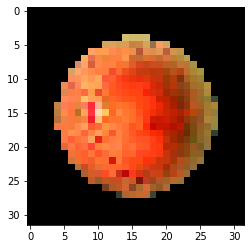

In [50]:
for image, label in train_named_ds.take(1):
  print(image.shape)
  plt.imshow(image.numpy())
  print('label: ', label.numpy())

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(train_named_ds,shuffle_buffer_size=5216)
test_ds = prepare_for_training(test_named_ds,shuffle_buffer_size=800)

image_batch, label_batch = next(iter(train_ds))

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(label_batch[n])
      plt.axis('off')

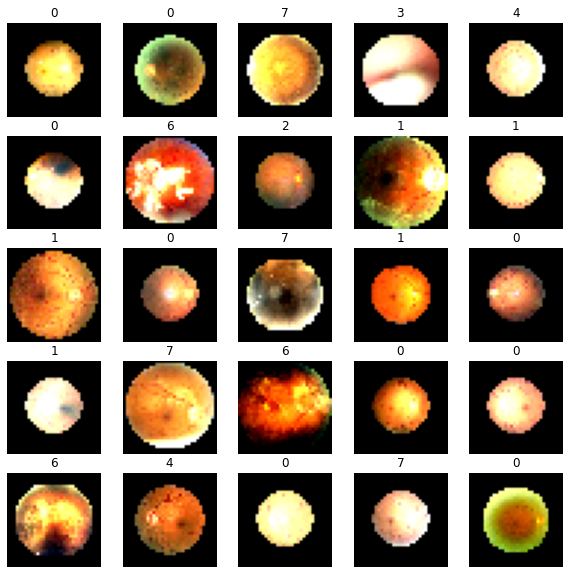

In [55]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [41]:
#calculating class weights
total = 3500*2
weight_for_N = (1 / N)*(total)/2.0 
weight_for_D = (1 / D)*(total)/2.0
weight_for_G = (1 / G)*(total)/2.0
weight_for_C = (1 / C)*(total)/2.0
weight_for_A = (1 / A)*(total)/2.0
weight_for_H = (1 / H)*(total)/2.0
weight_for_M = (1 / M)*(total)/2.0
weight_for_O = (1 / O)*(total)/2.0

class_weight = {0 : weight_for_N, 1 : weight_for_D, 2 : weight_for_G, 3 : weight_for_C, 4 : weight_for_A, 5 : weight_for_H, 6 : weight_for_M, 7 : weight_for_O}
print(class_weight)

{0: 1.3133208255159474, 1: 2.0539906103286385, 2: 12.455516014234874, 3: 14.95726495726496, 4: 16.055045871559635, 5: 45.45454545454546, 6: 14.644351464435145, 7: 6.055363321799308}


In [56]:
model_cnn = tf.keras.Sequential([
    
    # 1st VGG block
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(32, (3, 3), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),

    #2nd VGG block
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(128, (3, 3), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(8, activation = 'softmax')
])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        96        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        96        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [58]:
history_cnn = model_cnn.fit(train_ds.repeat(),
                    #batch_size=32,
                    epochs=100,
                    steps_per_epoch = 163, #train_elements/batch_size
                    validation_data=test_ds.repeat(),
                    validation_steps = 25,
                    #class_weight=class_weight
                    )

Epoch 1/100
163/163 [==============================] - 1s 7ms/step - loss: 1.6400 - accuracy: 0.4465 - val_loss: 1.5160 - val_accuracy: 0.4800
Epoch 2/100
163/163 [==============================] - 1s 7ms/step - loss: 1.5233 - accuracy: 0.4609 - val_loss: 1.5116 - val_accuracy: 0.4638
Epoch 3/100
163/163 [==============================] - 1s 7ms/step - loss: 1.5052 - accuracy: 0.4597 - val_loss: 1.4713 - val_accuracy: 0.4800
Epoch 4/100
163/163 [==============================] - 1s 7ms/step - loss: 1.4792 - accuracy: 0.4618 - val_loss: 1.4643 - val_accuracy: 0.4825
Epoch 5/100
163/163 [==============================] - 1s 7ms/step - loss: 1.4600 - accuracy: 0.4670 - val_loss: 1.4501 - val_accuracy: 0.4750
Epoch 6/100
163/163 [==============================] - 1s 7ms/step - loss: 1.4413 - accuracy: 0.4684 - val_loss: 1.4157 - val_accuracy: 0.4863
Epoch 7/100
163/163 [==============================] - 1s 7ms/step - loss: 1.4221 - accuracy: 0.4638 - val_loss: 1.4256 - val_accuracy: 0.4812

In [0]:
!rm -rf ODIR-5K/